In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working/'

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
# store features in pickle
# wb is for write binary
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
len(mapping)

8091

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
# preprocess the text
clean(mapping)

In [15]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
# Next we will store the preprocessed captions into a list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [19]:
# Now we start processing the text data

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

8485

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [22]:
# After preprocessing the data now we will train, test and split

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
# create data generator to get data in batch to avaoid syste crash

# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

def data_generator(dataaa_keys, mapping,features,tokenizer,max_length,vocab_size,batch_size):
    # loop over images
    x1,x2, y = list(), list(), list()
    n =0
    while 1:
        n += 1
        captions = mapping[key]
        # process sequence
        for caption in captions:
            seq = tokenizer.texts_to_sequences([caption])[0]
#             split the sequence in x y pairs
            for i in range(1, len(seq)):
                # split into input and out put pair
                in_seq, out_seq = seq[:1], seq[i]
                # put input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                x1.append(features[key][0])
                x2.append(in_seq)
                y.append(out_seq)
        if n == batch_size:
            x1,x2,y = np.array(x1), np.array(x2), np.array(y)
            yield [x1, x2], y
            x1, x2, y = list(), list(), list()
            n = 0


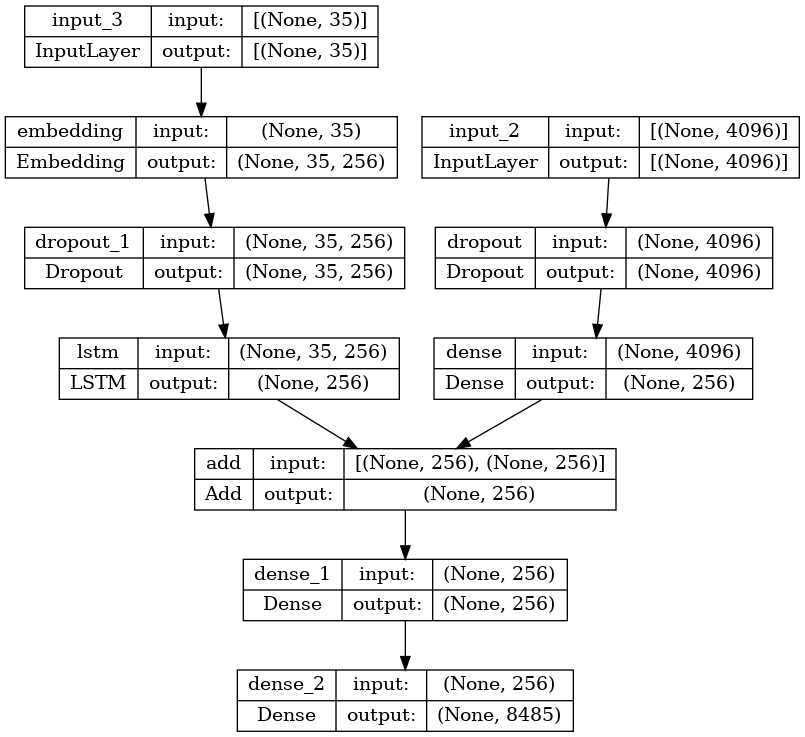

In [24]:

# Model Creation

# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [25]:
# train the model
# can add more epochs to increase the accuracy
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 561s 2s/step - loss: 2.8996


In [26]:
# You can save the model in the working directory for reuse

# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [27]:
# Generate Captions for the Image

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
            
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
# Now we validate the data using BLEU Score

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.027778
BLEU-2: 0.166667
BLEU-1: 0.0277

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.030236
BLEU-2: 0.002924
BLEU-1: 0.030484
BLEU-2: 0.002922
BLEU-1: 0.030458
BLEU-2: 0.002906
BLEU-1: 0.030432
BLEU-2: 0.002891
BLEU-1: 0.030407
BLEU-2: 0.002876
BLEU-1: 0.030382
BLEU-2: 0.002861
BLEU-1: 0.030358
BLEU-2: 0.002847
BLEU-1: 0.030334
BLEU-2: 0.002832
BLEU-1: 0.030311
BLEU-2: 0.002818
BLEU-1: 0.030288
BLEU-2: 0.002804
BLEU-1: 0.030265
BLEU-2: 0.002791
BLEU-1: 0.030243
BLEU-2: 0.002777
BLEU-1: 0.030221
BLEU-2: 0.002764
BLEU-1: 0.030200
BLEU-2: 0.002751
BLEU-1: 0.030179
BLEU-2: 0.002738
BLEU-1: 0.030397
BLEU-2: 0.002736
BLEU-1: 0.030375
BLEU-2: 0.002723
BLEU-1: 0.030353
BLEU-2: 0.002711
BLEU-1: 0.030331
BLEU-2: 0.002698
BLEU-1: 0.030310
BLEU-2: 0.002686
BLEU-1: 0.030289
BLEU-2: 0.002674
BLEU-1: 0.030269
BLEU-2: 0.002662
BLEU-1: 0.030248
BLEU-2: 0.002650
BLEU-1: 0.030228
BLEU-2: 0.002639
BLEU-1: 0.030209
BLEU-2: 0.002627
BLEU-1: 0.030190
BLEU-2: 0.002616
BLEU-1: 0.030171
BLEU-2: 0.002605
BLEU-1: 0.030152
BLEU-2: 0.002594
BLEU-1: 0.030133
BLEU-2: 0.002583
BLEU-1: 0.0301

In [30]:
# Visualize the Results
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------------Predicted--------------------
startseq in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in


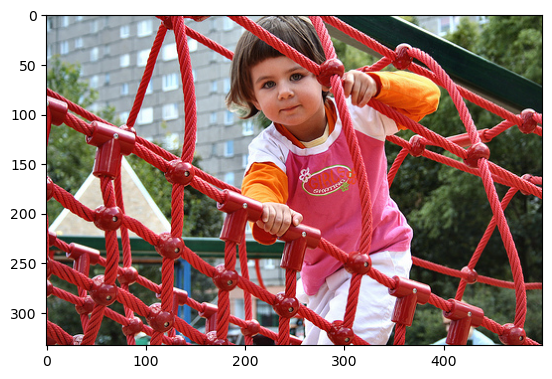

In [31]:
generate_caption("1007320043_627395c3d8.jpg")